In [2]:
import requests
import pandas as pd
import numpy as np
import cmocean
import matplotlib.pylab as plt
import datetime as dt
import gsw

In [3]:
#Modified from: https://www.itsonlyamodel.us/argovis-python-api.html

#Function to Argo profiles within a particular time period, lat/lon range
def get_selection_profiles(startDate, endDate, shape, presRange=None):
    baseURL = 'http://www.argovis.com/selection/profiles/'
    startDateQuery = '?startDate=' + startDate
    endDateQuery = '&endDate=' + endDate
    shapeQuery = '&shape='+shape
    if not presRange == None:
        pressRangeQuery = '&presRange=' + presRange
        url = baseURL + startDateQuery + endDateQuery + pressRangeQuery + shapeQuery
    else:
        url = baseURL + startDateQuery + endDateQuery + shapeQuery
#    print(url)
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    selectionProfiles = resp.json()
    return selectionProfiles

In [4]:
#function to put json object into a pandas dataframe

def parse_into_df(profiles):
    #initialize dict
    meas_keys = profiles[0]['measurements'][0].keys()
    df = pd.DataFrame(columns=meas_keys)
    for profile in profiles:
        #'measurements' has several components
        profileDf = pd.DataFrame(profile['measurements'])
        profileDf['cycle_number'] = profile['cycle_number']
        profileDf['profile_id'] = profile['_id']
        profileDf['lat'] = profile['lat']
        profileDf['lon'] = profile['lon']
        profileDf['date'] = profile['date']
        #next line puts profiles together consecutively: may need to break them apart later
        df = pd.concat([df, profileDf],sort=False)
    return df

In [5]:
#function to plot T-S profile for all identified profiles

def plot_ts(df, profile_ID):
    #use colors to color-code lines by month
    colors = {'1':'crimson','2':'coral', '3':'darkorange', '4': 'gold',
                '5': 'greenyellow','6':'green', '7':'lightseagreen','8':'mediumblue',
                '9':'mediumslateblue','10':'midnightblue','11':'purple','12':'orchid'}
    
    #set some default values for min/max T-S to compare with actual data
    smin=50
    tmin=100
    smax=0
    tmax=-10
    fig = plt.figure(figsize=(8,8))
    for prof in profile_ID:
        temp_prof=selectionDf[df['profile_id']==prof]
        smin=min(min(temp_prof['psal']),smin)
        tmin=min(min(temp_prof['temp']),tmin)
        smax=max(max(temp_prof['psal']),smax)
        tmax=max(max(temp_prof['temp']),tmax)
        plt.scatter(temp_prof['psal'],temp_prof['temp'],c=colors[str(temp_prof['date'].dt.month[0])])

    plt.xlabel('Salinity (psu)', fontsize=16)
    plt.ylabel('Temperature ($^{\circ}$)', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    #add density contours
    smin=smin-0.01*smin
    tmin=tmin-0.2*tmax
    smax=smax+0.01*smax
    tmax=tmax+0.1*tmax

    # Calculate how many gridcells we need in the x and y dimensions
    xdim = int(round((smax-smin)/0.1+1,0))
    ydim = int(round((tmax-tmin)+1,0))

    # Create empty grid of zeros
    density = np.zeros((ydim,xdim))
 
    # Create temp and salt vectors of appropiate dimensions
    ti = np.linspace(1,ydim-1,ydim)+tmin
    si = np.linspace(1,xdim-1,xdim)*0.1+smin

    # Loop to fill in grid with densities
    for j in range(0,int(ydim)):
        for i in range(0, int(xdim)):
            density[j,i]=gsw.sigma0(si[i], ti[j])    
    
    ax = fig.add_subplot(111)
    CS = ax.contour(si,ti,density, linestyles='dashed', colors='k')
    ax.clabel(CS, fontsize=12, fmt='%1.1f')
    
    plt.show()

In [6]:
#Set parameters for the box. These dates are the duration of the occupation of the 
#Southern Ocean OOI site
startDate='2014-09-01'
endDate='2018-08-22'
# shape should be nested array with lon, lat coords. Needs to be a CLOSED box
shape = '[[[-87.357,-52.408],[-87.357,-56.408],[-91.357,-56.408],[-91.357,-52.408],[-87.357,-52.408]]]'

In [7]:
#Get data using box parameters
selectionProfiles = get_selection_profiles(startDate, endDate, shape)
#if more than one profile, put into pandas Dataframe
if len(selectionProfiles) > 0:
    selectionDf = parse_into_df(selectionProfiles)
#replace Argo fill values with pandas fill value
selectionDf.replace(-999, np.nan, inplace=True)
#convert date to a more convenient format
selectionDf["date"] = pd.to_datetime(selectionDf["date"])

In [8]:
#Identify unique profile markers to give option of breaking data fram apart into 
#individual profiles
uniq_prof=selectionDf.profile_id.unique()
floats=[prof[0:7] for prof in uniq_prof]

33.624360694885254 35.041730079650875 0.2400000572204588 10.58199987411499


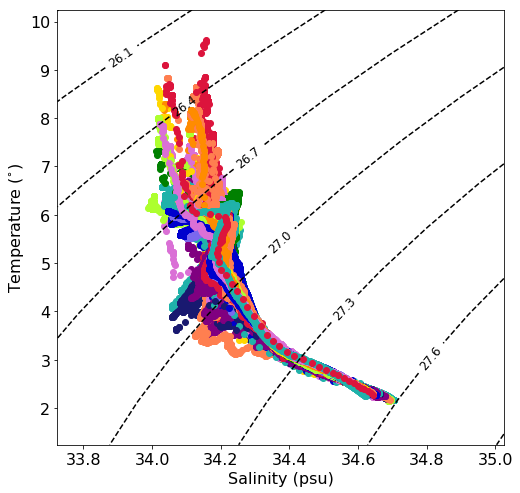

In [9]:
#Make a T-S plot of the data
plot_ts(selectionDf,uniq_prof)